In [ ]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
RANDOM_SEED = 2020

In [ ]:
# import data set
from google.colab import drive
from google.colab import files # to save images
drive.mount('/content/gdrive')
csv_data = 'gdrive/My Drive/Colab Notebooks/ML lab/Lab1/data/high_diamond_ranked_10min.csv'
data_df = pd.read_csv(csv_data, sep=',')
data_df = data_df.drop(columns='gameId')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# initial inspection
print(data_df.iloc[0])
data_df.describe()
data_df.shape
# print(data_df.iloc[:,0].tolist().count(0))

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueFirstBlood                      1.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
blueGoldDiff                      643.0
blueExperienceDiff                 -8.0
blueCSPerMin                       19.5
blueGoldPerMin                   1721.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redFirstBlood                       0.0
redKills                            6.0
redDeaths                           9.0


(9879, 39)

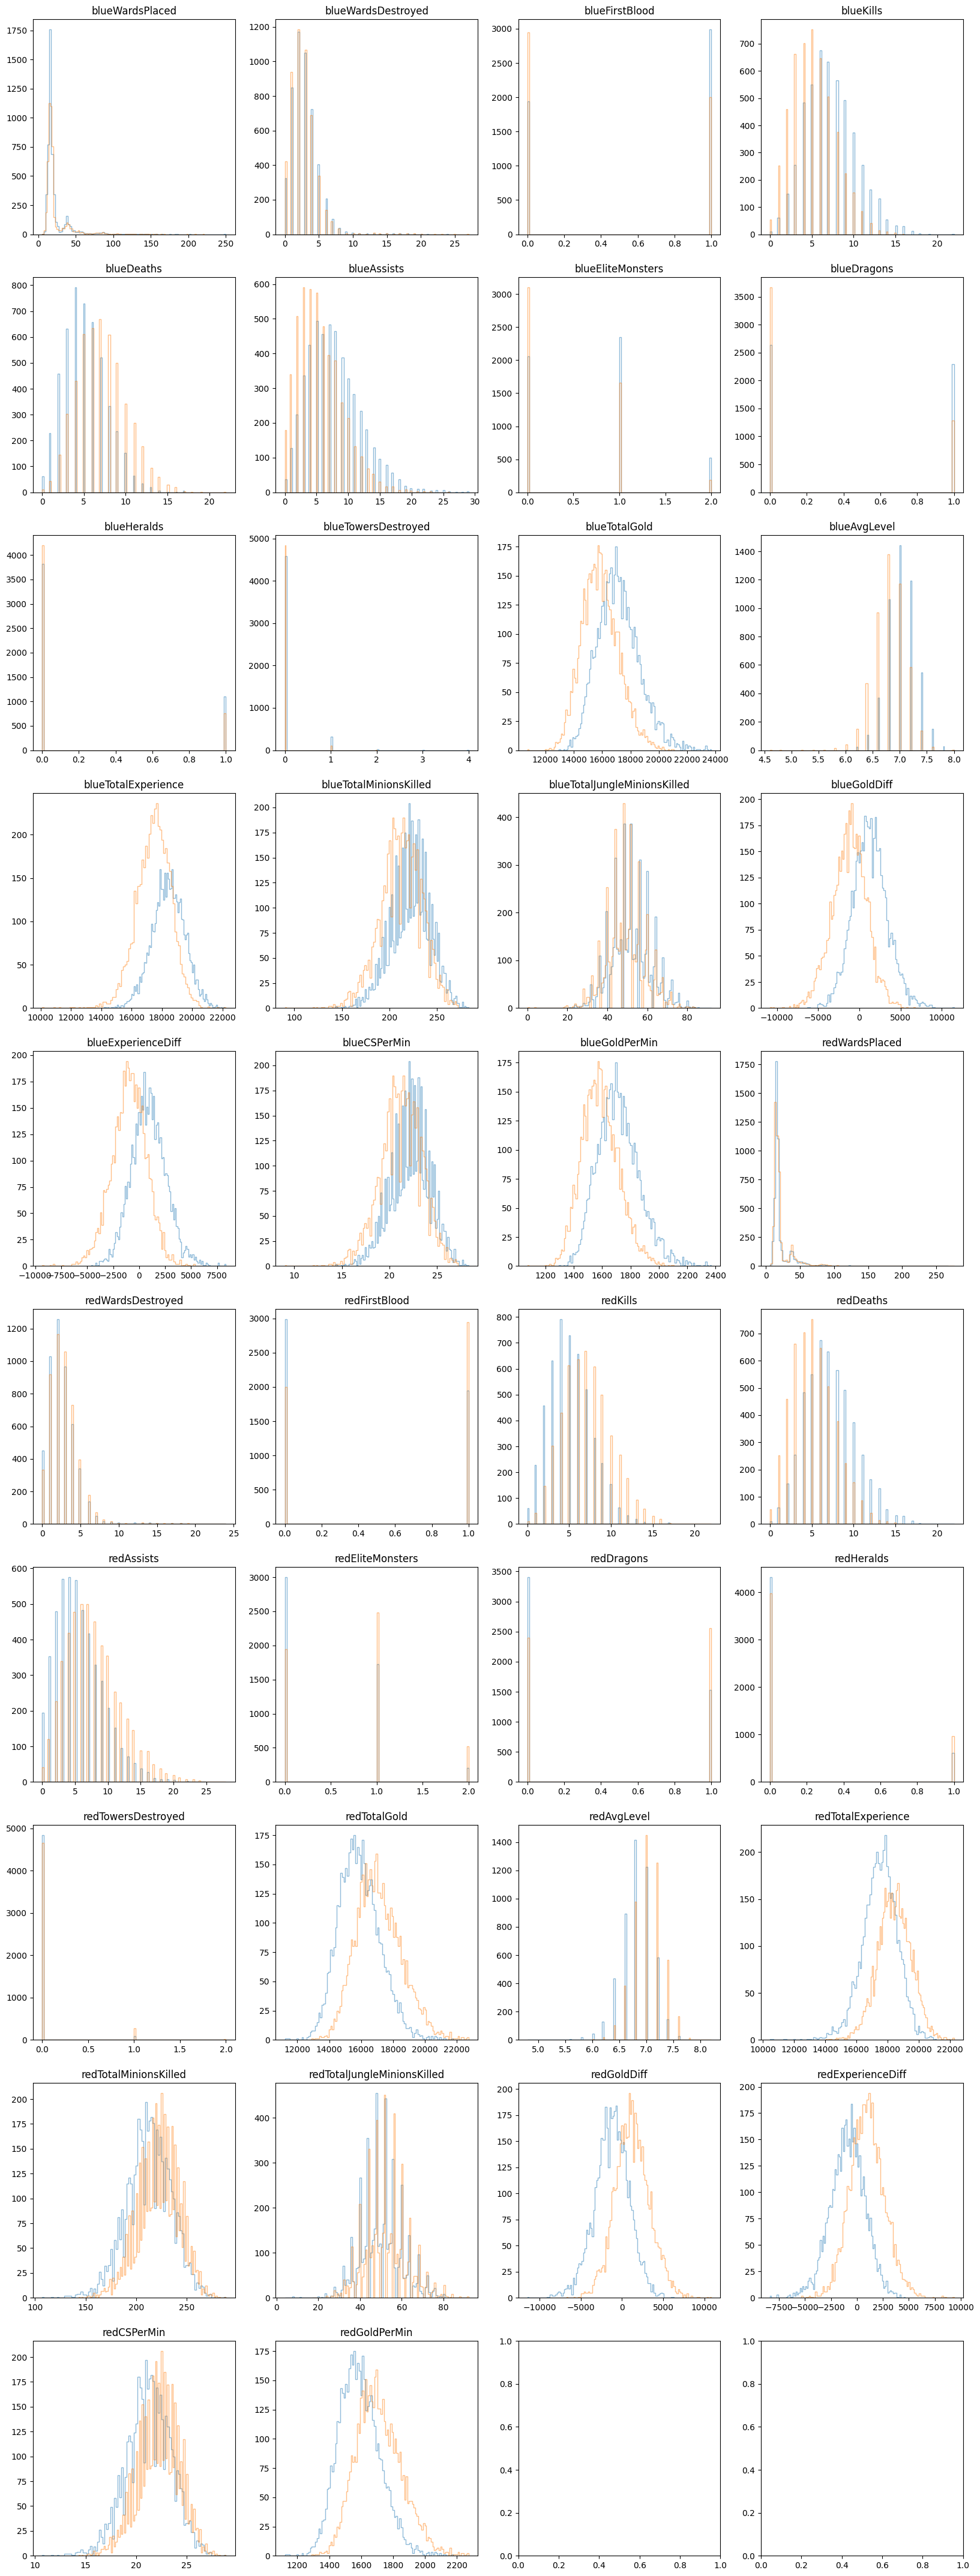

In [ ]:
# inspect after removal of some features
import matplotlib.pyplot as plt

figure, axes = plt.subplots(10, 4, figsize = (20,56), dpi = 100)
ax = axes.flatten()
for i, c in enumerate(data_df.columns[1:]):
  ax[i].hist(data_df.loc[data_df['blueWins'] == 1][c], bins = 100, alpha = 0.5, histtype = 'step')
  ax[i].hist(data_df.loc[data_df['blueWins'] == 0][c], bins = 100, alpha = 0.5, histtype = 'step')
  ax[i].set_title(c)

# plt.savefig("beforebinning.png")
# files.download("beforebinning.png")
plt.show()

In [ ]:
# remove redundant features and add new features
drop_features = ['blueGoldDiff', 'redGoldDiff', 
                 'blueExperienceDiff', 'redExperienceDiff', 
                 'blueCSPerMin', 'redCSPerMin', 
                 'blueGoldPerMin', 'redGoldPerMin']
df = data_df.drop(columns=drop_features)
info_names = [c[3:] for c in df.columns if c.startswith('red')]
for info in info_names:
    df['br' + info] = df['blue' + info] - df['red' + info]
df = df.drop(columns=['blueFirstBlood', 'redFirstBlood']) 
print(df.iloc[0])
df.describe()

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redKills                            6.0
redDeaths                           9.0
redAssists                          8.0
redEliteMonsters                    0.0
redDragons                          0.0
redHeralds                          0.0
redTowersDestroyed                  0.0
redTotalGold                    16567.0


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,brWardsPlaced,brWardsDestroyed,brFirstBlood,brKills,brDeaths,brAssists,brEliteMonsters,brDragons,brHeralds,brTowersDestroyed,brTotalGold,brAvgLevel,brTotalExperience,brTotalMinionsKilled,brTotalJungleMinionsKilled
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,16503.455512,6.916004,17928.110133,216.699565,50.509667,22.367952,2.723150,6.137666,6.183925,6.662112,0.573135,0.413098,0.160036,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-0.079664,0.101731,0.009616,0.046260,-0.046260,-0.017006,-0.023180,-0.051119,0.027938,0.008402,14.414111,-0.009313,-33.620306,-0.649661,-0.803421
std,0.500024,18.019177,2.174998,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,1535.446636,0.305146,1200.523764,21.858437,9.898282,18.457427,2.138356,2.933818,3.011028,4.060612,0.626482,0.492415,0.366658,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,25.960582,2.854910,1.000004,4.195489,4.195489,5.766787,1.067934,0.878945,0.589292,0.324835,2453.349179,0.478434,1920.370438,30.942675,14.274733
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,4.600000,10098.000000,90.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-260.000000,-23.000000,-1.000000,-17.000000,-16.000000,-25.000000,-2.000000,-1.000000,-1.000000,-2.000000,-10830.000000,-2.600000,-9333.000000,-120.000000,-72.000000
25%,0.000000,14.000000,1.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15415.500000,6.800000,17168.000000,202.000000,44.000000,14.000000,1.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-4.000000,-1.000000,-1.000000,-3.000000,-3.000000,-4.000000,-1.000000,-1.000000,0.000000,0.000000,-1585.500000,-0.400000,-1290.500000,-21.000000,-10.000000
50%,0.000000,16.000000,3.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16398.000000,7.000000,17951.000000,218.000000,50.000000,16.000000,2.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,-28.000000,-1.000000,0.000000
75%,1.000000,20.000000,4.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17459.000000,7.200000,18724.000000,232.000000,56.000000,20.000000,4.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,4.000000,1.000000,1.000000,3.000000,3.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1596.000000,0.200000,1212.000000,20.000000,8.000000
max,1.000000,250.000000,27.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,23701.000000,8.000000,22224.000000,283.000000,92.000000,276.000000,24.000000,22.00

In [ ]:
# remove features that have minimal impact on the output
df = df.drop(columns = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueTotalJungleMinionsKilled',
                        'redWardsPlaced', 'redWardsDestroyed', 'redTotalJungleMinionsKilled',
                        'brWardsPlaced', 'brWardsDestroyed', 'brTotalJungleMinionsKilled'])

len(df.columns[1:])

34

In [ ]:
# quantize each feature
def binning(df, numOfBins, method):
  discrete_df = df.copy()

  for c in df.columns[1:]:
    # skip the some features
    if c == 'blueEliteMonsters' or c == 'blueDragons' or c == 'blueHeralds' or c == 'blueTowersDestroyed': continue
    if c == 'redEliteMonsters' or c == 'redDragons' or c == 'redHeralds' or c == 'redTowersDestroyed': continue
    if c ==  'brFirstBlood' or c == 'brEliteMonsters' or c == 'brDragons' or c == 'brHeralds' or c == 'brTowersDestroyed': continue

    # method 1. trim off the extreme values and cut the range into equal width
    if method == 'equalwidth':
      win = df.loc[df['blueWins'] == 1][c].tolist()
      lose = df.loc[df['blueWins'] == 0][c].tolist()
      win.sort()
      lose.sort()
      lower = win[int(0.01*len(win))]
      upper = lose[int(0.99*len(lose))]
      step = int((upper - lower)*1000/numOfBins)
      bins = [-np.inf] + [i/1000 for i in list(range(int(lower*1000), int(upper*1000), step))] + [upper, np.inf]
      discrete_df[c] = pd.cut(discrete_df[c], bins, labels = False)

    # method 2 equal frequency
    if method == 'equalfrequency':
      l = df[c].tolist()
      l.sort()
      lower = l[int(0.01*len(l))]
      upper = l[int(0.99*len(l))]
      bins = [-np.inf, lower, upper, np.inf]
      for i in range(1, numOfBins):
        edge = l[int((i/numOfBins)*len(l))]
        bins.append(edge)
      bins = list(set(bins))
      bins.sort()
      discrete_df[c] = pd.cut(discrete_df[c], bins, labels = False)

  return discrete_df

discrete_df1 = binning(df, 7, 'equalwidth')
discrete_df2 = binning(df, 7, 'equalfrequency')
discrete_df1.shape, discrete_df2.shape

((9879, 35), (9879, 35))

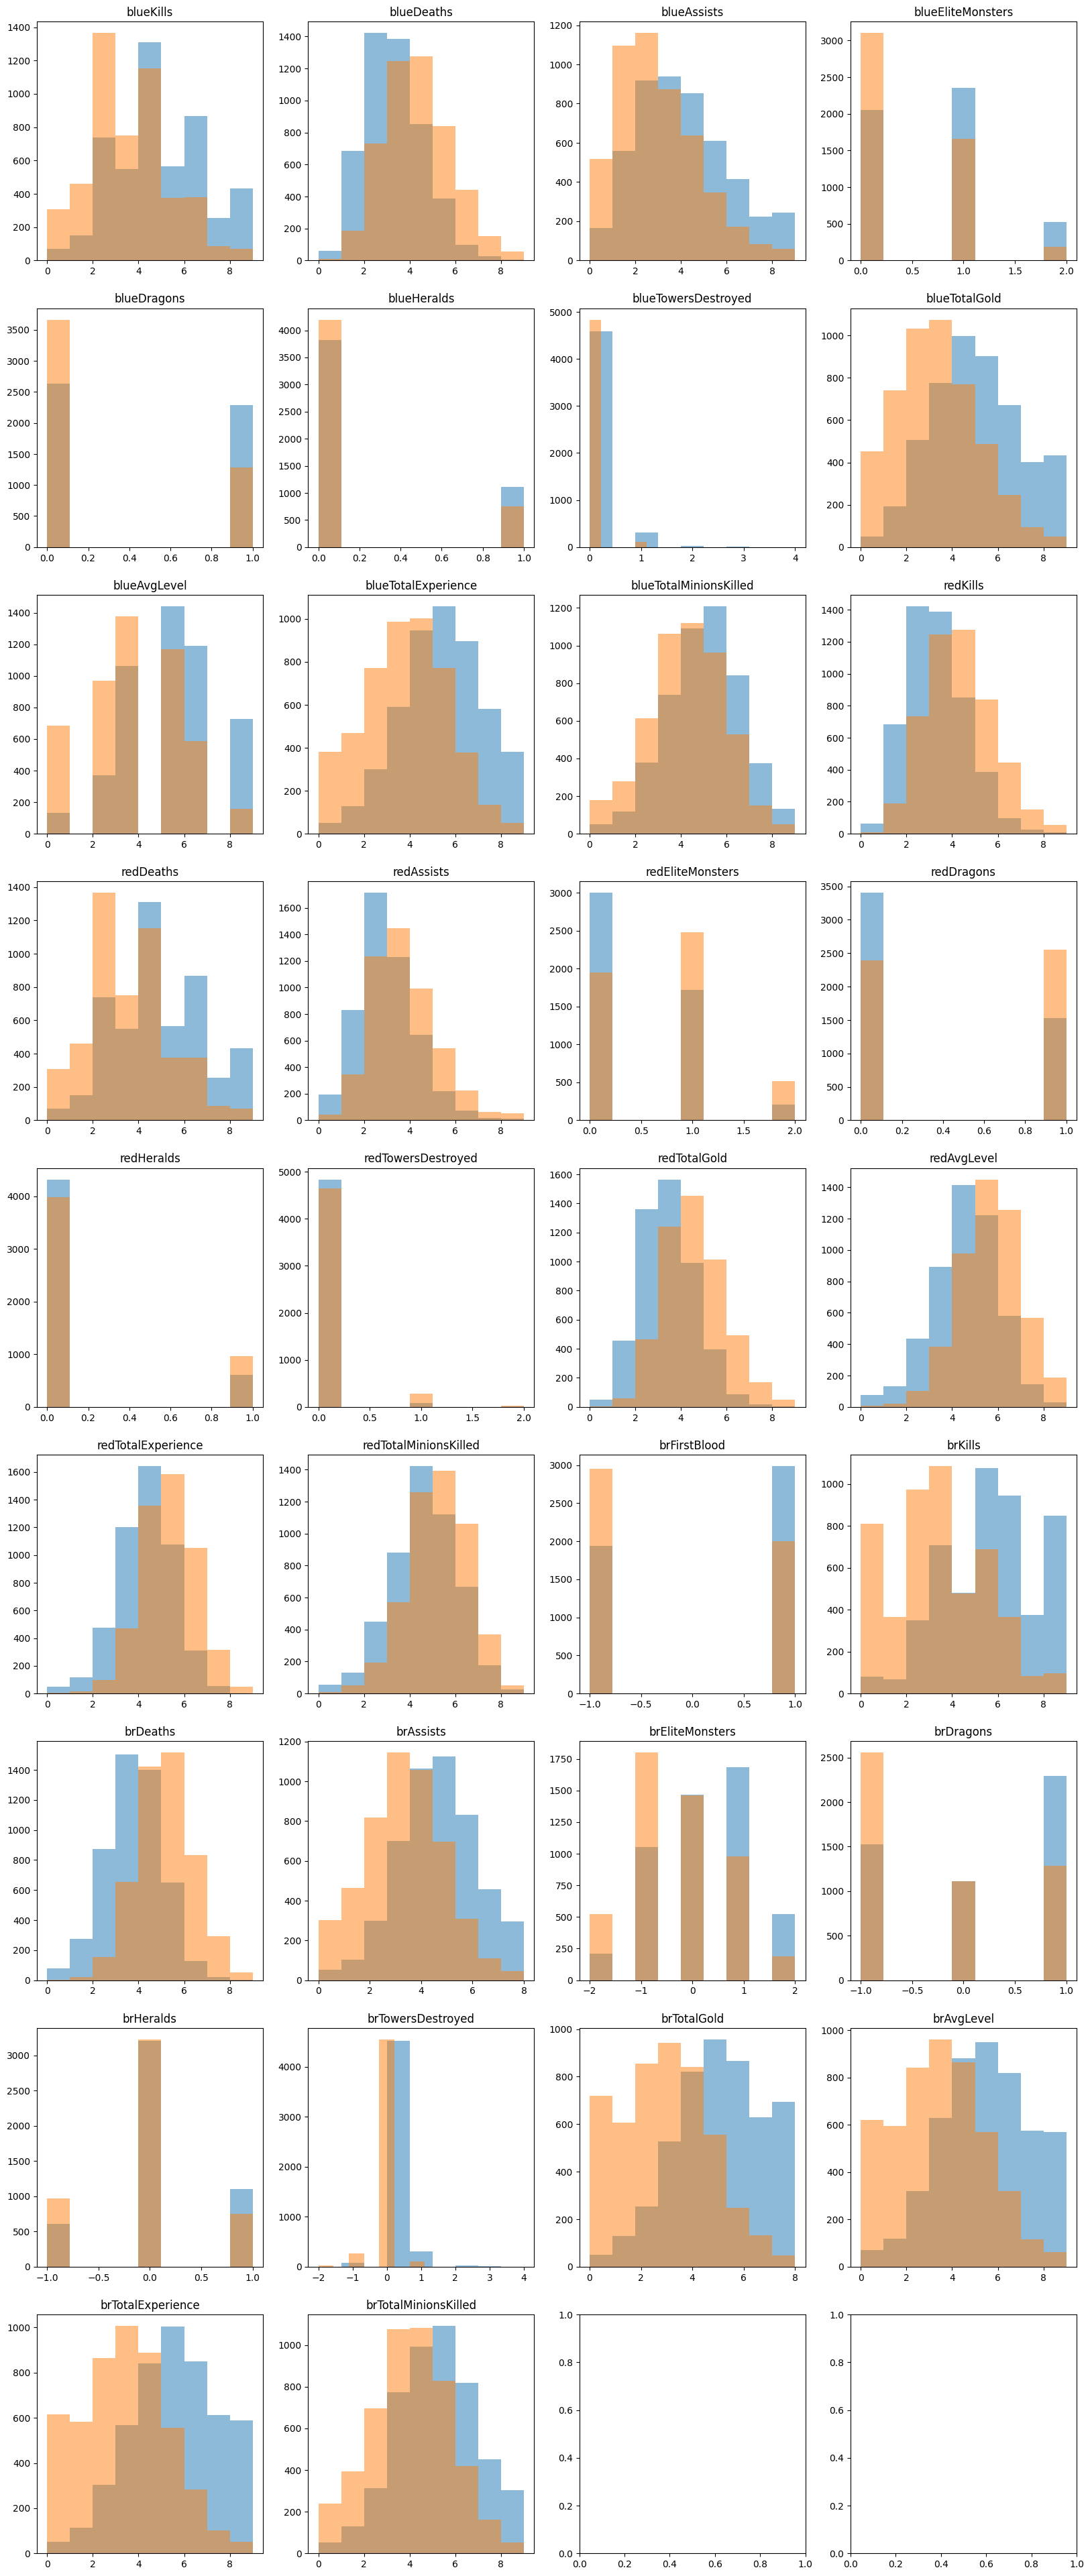

In [ ]:
# after binning, inspect again
figure, axes = plt.subplots(9, 4, figsize = (20,50), dpi = 100)
ax = axes.flatten()
for i, c in enumerate(discrete_df1.columns[1:]):
  ax[i].hist(discrete_df1.loc[df['blueWins'] == 1][c], bins = 9, alpha = 0.5)
  ax[i].hist(discrete_df1.loc[df['blueWins'] == 0][c], bins = 9, alpha = 0.5)
  ax[i].set_title(c)

# plt.savefig("afterbinning_equalwitdth.png")
# files.download("afterbinning_equalwitdth.png")
plt.show()

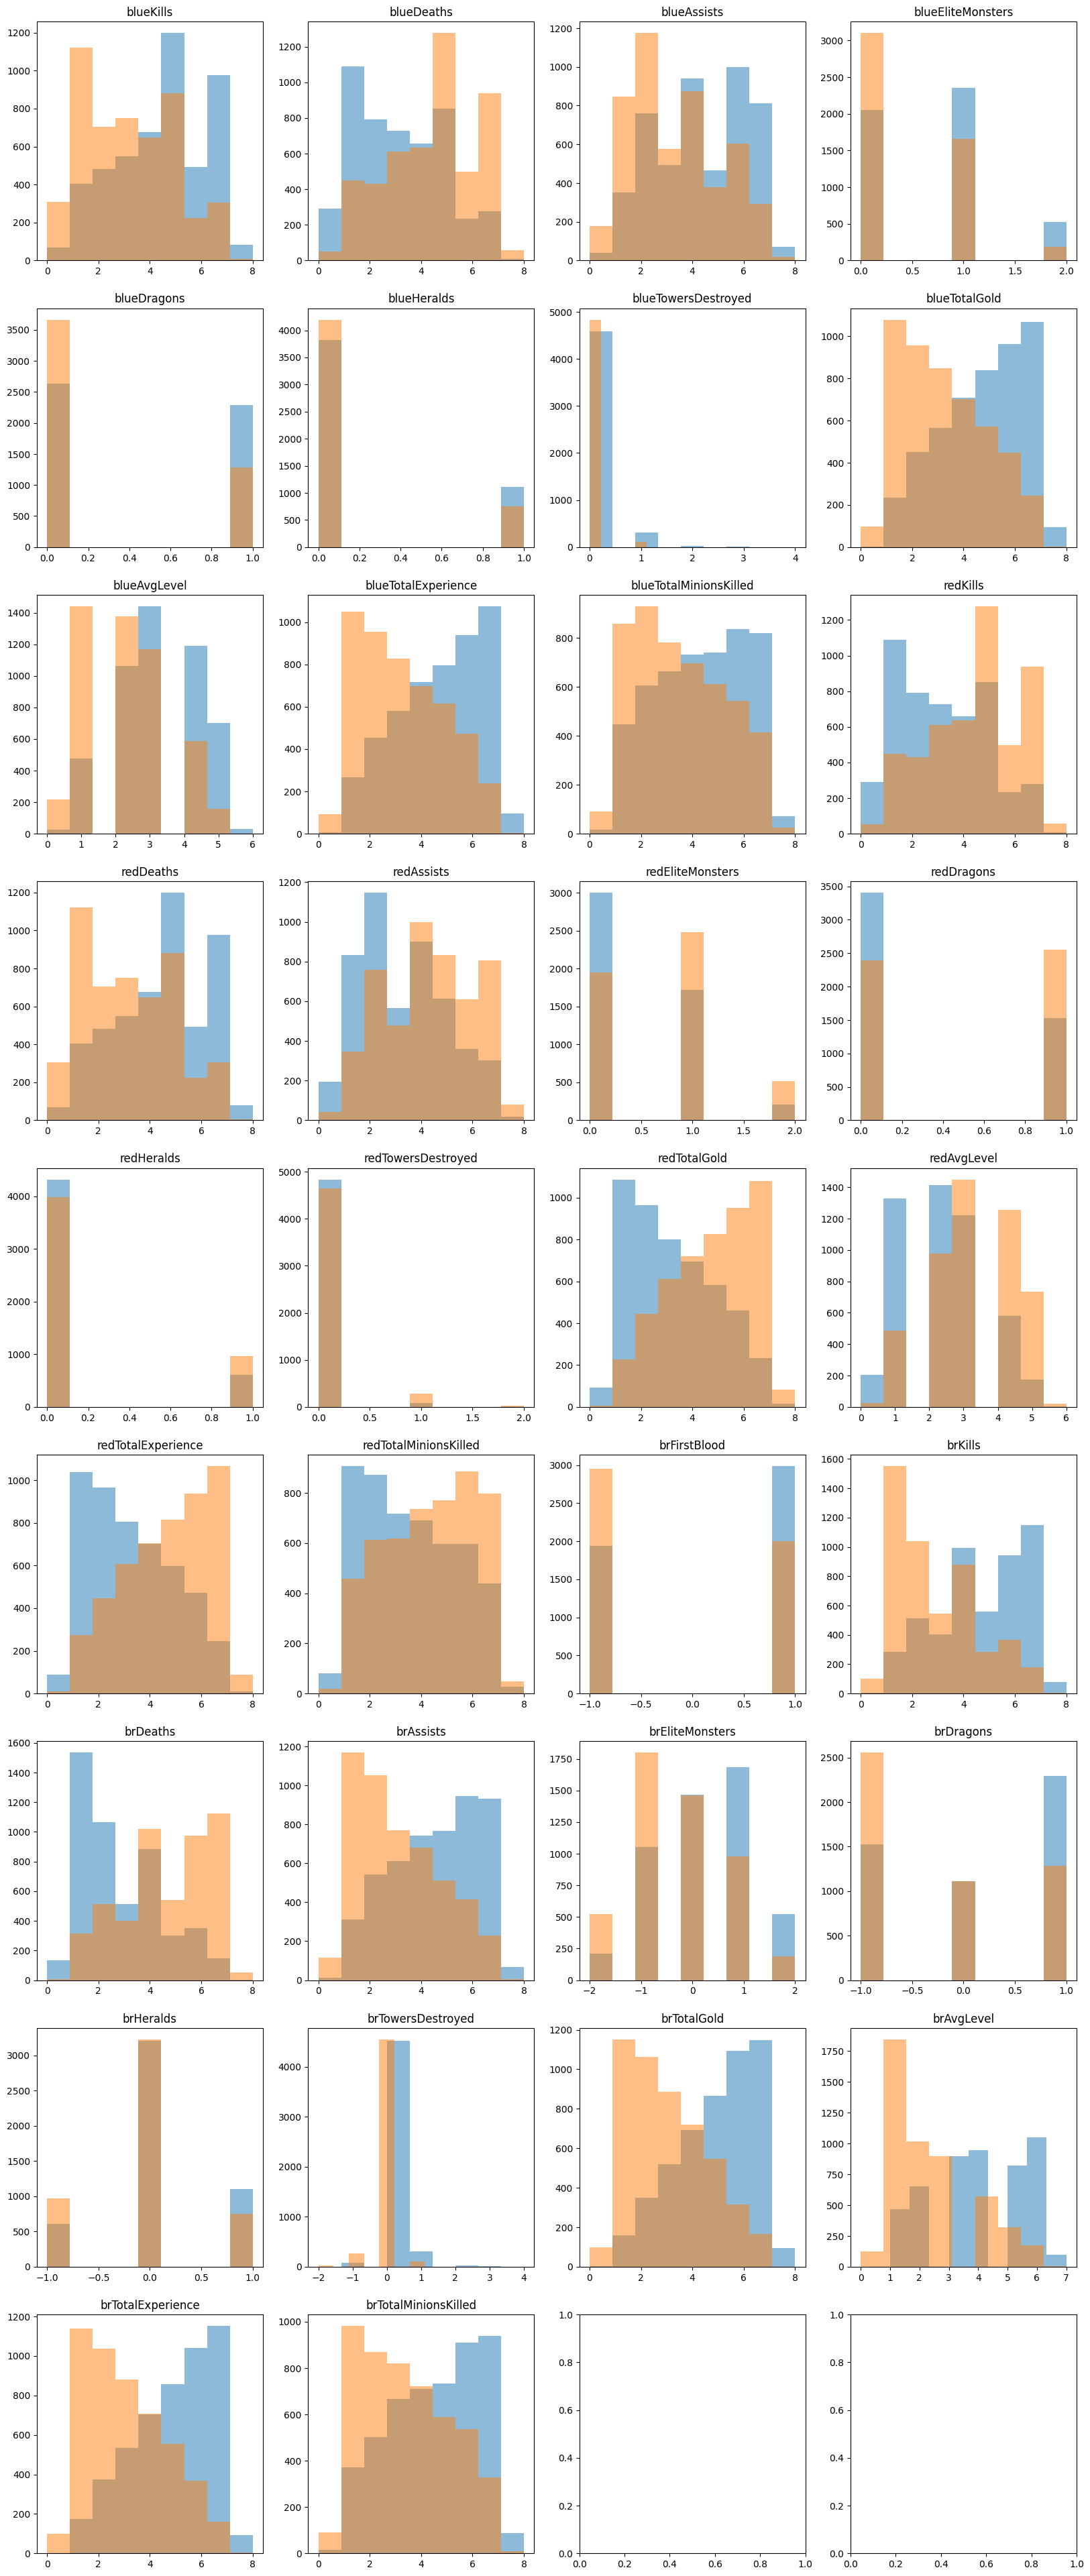

In [ ]:
# try using equal frequency method for binning
figure, axes = plt.subplots(9, 4, figsize = (20,50), dpi = 100)
ax = axes.flatten()
for i, c in enumerate(discrete_df2.columns[1:]):
  ax[i].hist(discrete_df2.loc[df['blueWins'] == 1][c], bins = 9, alpha = 0.5)
  ax[i].hist(discrete_df2.loc[df['blueWins'] == 0][c], bins = 9, alpha = 0.5)
  ax[i].set_title(c)

# plt.savefig("afterbinning_equalfrequency.png")
# files.download("afterbinning_equalfrequency.png")
plt.show()

In [ ]:
# split the discrete_df1 into training set and test set
all_y1 = discrete_df1['blueWins'].values # label
feature_names1 = discrete_df1.columns[1:] 
all_x1 = discrete_df1[feature_names1].values

x_full_train1, x_test1, y_full_train1, y_test1 = train_test_split(all_x1, all_y1, test_size = 0.2, random_state = RANDOM_SEED)
all_y1.shape, all_x1.shape, x_full_train1.shape, x_test1.shape, y_full_train1.shape, y_test1.shape

# split into training set and validation set
x_train1, x_validate1, y_train1, y_validate1 = train_test_split(x_full_train1, y_full_train1, test_size = 0.1, random_state = RANDOM_SEED)
x_train1.shape, x_validate1.shape, y_train1.shape, y_validate1.shape

((7112, 34), (791, 34), (7112,), (791,))

In [ ]:
# split the discrete_df2 into training set and test set
all_y2 = discrete_df2['blueWins'].values # label
feature_names2 = discrete_df2.columns[1:] 
all_x2 = discrete_df2[feature_names2].values

x_full_train2, x_test2, y_full_train2, y_test2 = train_test_split(all_x2, all_y2, test_size = 0.2, random_state = RANDOM_SEED)
all_y2.shape, all_x2.shape, x_full_train2.shape, x_test2.shape, y_full_train2.shape, y_test2.shape

# split into training set and validation set
x_train2, x_validate2, y_train2, y_validate2 = train_test_split(x_full_train2, y_full_train2, test_size = 0.1, random_state = RANDOM_SEED)
x_train2.shape, x_validate2.shape, y_train2.shape, y_validate2.shape

((7112, 34), (791, 34), (7112,), (791,))

In [ ]:
# Decision Tree Classifier Model
import math

class Node(object):
  def __init__(self):
    self.value = None
    self.next = None
    self.childs = None

class DecisionTree(object):
  def __init__(self, categories, feature_names, max_depth = 10, min_samples_split=10, impurity_t = 'entropy'):
    self.categories = categories 
    self.feature_names = feature_names.tolist()
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.impurity_t = impurity_t
    self.root = None
 
  def fit(self, X, y):
    assert len(self.feature_names) == len(X[0])
    # assign an unique number to each instance
    x_ids = [i for i in range(len(X))]
    # assign an unique number to each feature
    feature_ids = [i for i in range(len(self.feature_names))]
    # init root node
    self.root = self._expand_node(x_ids, feature_ids, X, y, self.root)
    

  def predict(self, X):
    assert len(X.shape) == 1 or len(X.shape) == 2

    # only one instance is given
    if len(X.shape) == 1: 
      feature_ids = [feature_id for feature_id in X]
      return self._traverse_node(X, self.root)

    # predict a group of samples
    if len(X.shape) == 2:
      n, m = X.shape
      feature_ids = [feature_id for feature_id in X[0]]
      return [ self._traverse_node(X[i], self.root) for i in range(n)]

  

  # for building the model
  def _expand_node(self, x_ids, feature_ids, X, y, node):
    feature_ids = list(feature_ids)

    # init a node
    if not node:
      node = Node()

    # sort label values by instance id
    labels_in_features = [y[i] for i in x_ids]

    # if exceeds the threshold values, return mode(y)
    if (len(self.feature_names) - len(feature_ids) > self.max_depth) or (len(x_ids) <= self.min_samples_split):
      node.value = max(set(labels_in_features), key = labels_in_features.count)
      return node
  
    # if all the sample have the same y values, return mode(y)
    if self._all_equal(labels_in_features):
      node.value = labels_in_features[0]
      return node  


    # if all input features are the same
    if self._all_equal(X.tolist()):
      node.value = max(set(labels_in_features), key = labels_in_features.count)
      return node
    
    # if there are not more feature to compute, return mode(y)
    if len(feature_ids) == 0:
      node.value = max(set(labels_in_features), key=labels_in_features.count)  # compute mode
      return node

    # choose the feature that maximizes the information gain
    best_feature_name, best_feature_id = self._get_feature_max_information_gain(x_ids, feature_ids, X, y, 0.01)
    # prepruning - if the max information gain is less than 0.01
    if not best_feature_name and not best_feature_id:
      node.value = max(set(labels_in_features), key=labels_in_features.count)
      return node
    node.value = best_feature_name
    # print( 'depth {} : {}'.format(len(self.feature_names) - len(feature_ids), node.value))
    node.childs = []
    # unique value of the chosen feature for each instance
    feature_values = list(set(X[:, best_feature_id]))
    # loop through all the values
    for value in feature_values:
      child = Node()
      child.value = value 
      node.childs.append(child)
      child_x_ids = [i for i in x_ids if X[i][best_feature_id] == value]
      if not child_x_ids:
        child.next = Node()
        child.next.value = max(set(labels_in_features), key = labels_in_features.count)
      else:
        if feature_ids and best_feature_id in feature_ids:
          feature_ids.remove(best_feature_id)
        #recursively call _expand_node
        child.next = self._expand_node(child_x_ids, feature_ids, X, y, child.next)
    return node


  # for prediction
  def _traverse_node(self, X, node):
    # if it's a leaf node
    if not node.childs and not node.next:
      return node.value

    # if it's a feature node
    if node.childs:
      feature_name = node.value 
      feature_id = self.feature_names.index(feature_name)
      # find the correct child to walk into
      for child in node.childs:
        if child.value == X[feature_id]:
          return self._traverse_node(X, child.next)
          
      raise Exception("unseen category")

    # print(X) 
    raise Exception("invalid node")



  # calculate the information gain
  def _get_information_gain(self, x_ids, feature_id, X, y):
    # choose a method
    if self.impurity_t == 'gini':
      _cal_gain = self._cal_gini
    elif self.impurity_t == 'entropy':
      _cal_gain = self._cal_entropy
    elif self.impurity_t == 'classification_error':
      _cal_gain = self._cal_classification_error
    else:
      raise Exception("invalid method for impurity test")
    # calculate the info gain at current level/depth
    cur_info_gain = _cal_gain(x_ids, y)
    # store all the values of the chosen feature
    x_features = [X[i][feature_id] for i in x_ids]
    # get unique values
    feature_vals = list(set(x_features))
    # get frequency of each value
    feature_v_count = [x_features.count(val) for val in feature_vals]
    # get the subset ids
    feature_v_id = [[x_ids[i] for i, x in enumerate(x_features) if x == val] for val in feature_vals]
    info_gain_feature = sum([v_counts/len(x_ids)*_cal_gain(v_ids, y) for v_counts, v_ids in zip(feature_v_count, feature_v_id)])
    return cur_info_gain - info_gain_feature


  # find the maximum information gain feature
  def _get_feature_max_information_gain(self, x_ids, feature_ids, X, y, threshold):
    # get the entropy for each feature
    features_entropy = [self._get_information_gain(x_ids, feature_id, X, y) for feature_id in feature_ids]
    max_feature_entropy = max(features_entropy)

    # prepruning
    if max_feature_entropy < threshold:
      return None, None

    # find the feature that maximizes the information gain
    max_id = feature_ids[features_entropy.index(max_feature_entropy)]
    return self.feature_names[max_id], max_id


  # calculate entropy 
  def _cal_entropy(self, x_ids, y):
    labels = [y[i] for i in x_ids]
    label_count = [labels.count(c) for c in self.categories]
    entropy = sum([-count/len(x_ids)*math.log(count/len(x_ids),2) if count else 0 for count in label_count])
    return entropy

  # calculate gini
  def _cal_gini(self, x_ids, y):
    labels = [y[i] for i in x_ids]
    label_count = [labels.count(c) for c in self.categories]
    gini = 1-sum([(count/len(x_ids))**2 if count else 0 for count in label_count])
    return gini

  # calculate classification error
  def _cal_classification_error(self, x_ids, y):
    labels = [y[i] for i in x_ids]
    label_count = [labels.count(c) for c in self.categories]
    error = 1-max([count/len(x_ids) if count else 0 for count in label_count])
    return error

  # utility function for equality check
  def _all_equal(self, iterable):
    it = iter(iterable)
    first = next(it)
    return all(first == x for x in iterable)



In [ ]:
# use gini to calculate information gain on data set discrete_df1
DT_gini1 = DecisionTree(categories = [0,1], feature_names = feature_names1, max_depth = 5, min_samples_split = 10, impurity_t = 'gini')
DT_gini1.fit(x_train1, y_train1)
p_test = DT_gini1.predict(x_test1)
print(p_test)
test_acc = accuracy_score(p_test, y_test1)
print('accuracy: {:.4f}'.format(test_acc))

[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 

In [ ]:
# use gini to calculate information gain on data set discrete_df2
DT_gini2 = DecisionTree(categories = [0,1], feature_names = feature_names2, max_depth = 5, min_samples_split = 10, impurity_t = 'gini')
DT_gini2.fit(x_train2, y_train2)
p_test = DT_gini2.predict(x_test2)
print(p_test)
test_acc = accuracy_score(p_test, y_test2)
print('accuracy: {:.4f}'.format(test_acc))

[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 

In [ ]:
# postpruning functions
# method used: Reduced Error Pruning

# post order traversal
def greedypruning(DT, DTnode, best_accuracy, acc, numOfNodes, x_validate, y_validate):
  # if it is a leaf node
  if not DTnode.next and not DTnode.childs:
    return None

  # if it is a feature node
  if DTnode.childs:
    for child_node in DTnode.childs:
      greedypruning(DT, child_node, best_accuracy, acc, numOfNodes, x_validate, y_validate)

  # if it is a child/branch node
  if not DTnode.childs:
    greedypruning(DT, DTnode.next, best_accuracy, acc, numOfNodes, x_validate, y_validate)
    # if the next node is not a leaf node
    if isinstance(DTnode.next.value, str):
      # try prune a branch
      childs = DTnode.next.childs
      value = DTnode.next.value
      DTnode.next.childs = None
      best_value = -1
      flag = False
      for c in DT.categories:
        DTnode.next.value = c
        test_acc = test(DT, x_validate, y_validate)
        if best_accuracy < test_acc:
          best_accuracy = test_acc
          best_value = c
          flag = True

      if not flag:
        # if no better accuracies found, restore the original node
        DTnode.next.childs = childs
        DTnode.next.value = value
      else:
        DTnode.next.value = best_value
        # note down
        acc.append(best_accuracy)
        numOfNodes.append(countNodes(DT.root))

# test accuracy score for a given tree model
def test(DT, X, y):
  p = DT.predict(X)
  acc = accuracy_score(p, y)
  return acc

# counts the number of nodes in a given tree
def countNodes(DTnode):
  if not DTnode.childs and not DTnode.next:
    return 1
  count = 0
  if isinstance(DTnode.value, str):
    for child in DTnode.childs:
        count += countNodes(child.next)
  return count+1


In [ ]:
# post pruning on DT_gini1 (discrete_df1 + gini)
import copy
DT1 = copy.deepcopy(DT_gini1)
acc_gini1 = []
numOfNodes_gini1 = []

best_accuracy = test(DT1, x_validate1, y_validate1)
acc_gini1.append(best_accuracy)
numOfNodes_gini1.append(countNodes(DT1.root))

print('accuracy score on test set before postpruning: {:.4f}'.format(test(DT1, x_test1, y_test1)))
greedypruning(DT1, DT1.root, best_accuracy, acc_gini1, numOfNodes_gini1, x_validate1, y_validate1)
print('accuracy score on test set after postpruning: {:.4f}'.format(test(DT1, x_test1, y_test1)))

accuracy score on test set before postpruning: 0.6791
accuracy score on test set after postpruning: 0.7100


In [ ]:
# post pruning on DT_gini2 (discrete_df2 + gini)
acc_gini2 = []
numOfNodes_gini2 = []

best_accuracy = test(DT_gini2, x_validate2, y_validate2)
acc_gini2.append(best_accuracy)
numOfNodes_gini2.append(countNodes(DT_gini2.root))

print('accuracy score on test set before postpruning: {:.4f}'.format(test(DT_gini2, x_test2, y_test2)))
greedypruning(DT_gini2, DT_gini2.root, best_accuracy, acc_gini2, numOfNodes_gini2, x_validate2, y_validate2)
print('accuracy score on test set after postpruning: {:.4f}'.format(test(DT_gini2, x_test2, y_test2)))

accuracy score on test set before postpruning: 0.6999
accuracy score on test set after postpruning: 0.7115


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

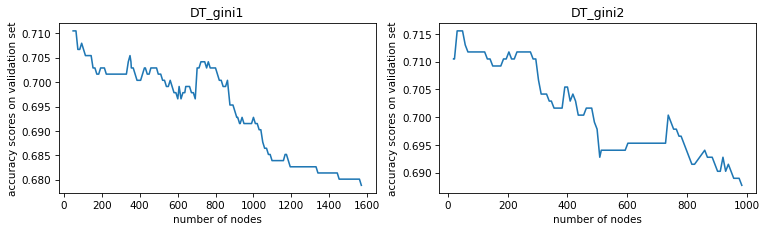

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12, 3), dpi=75)
ax1.plot(numOfNodes_gini1, acc_gini1)
ax1.set_ylabel("accuracy scores on validation set")
ax1.set_xlabel("number of nodes")
ax1.set_title("DT_gini1")
ax2.plot(numOfNodes_gini2, acc_gini2)
ax2.set_ylabel("accuracy scores on validation set")
ax2.set_xlabel("number of nodes")
ax2.set_title("DT_gini2")

# plt.savefig("DT_gini_comparison.png")
# files.download("DT_gini_comparison.png")

In [ ]:
# print only the feautures of the tree
def print_tree(DT, node):
  if node.value in DT.feature_names:
    print(node.value)
    for child in node.childs:
        print_tree(DT, child.next)
  
print("DT_gini1 feature nodes: ")
print_tree(DT1, DT1.root)
print("==================================")
print("DT_gini2 feature nodes: ")
print_tree(DT_gini2, DT_gini2.root)


DT_gini1 feature nodes: 
brTotalGold
blueTotalGold
brAvgLevel
brKills
blueTotalExperience
DT_gini2 feature nodes: 
brTotalGold
blueAssists


In [ ]:
# try using entropy for calculating information gain on discrete_df1
DT_ent1 = DecisionTree(categories = [0,1], feature_names = feature_names1, max_depth = 5, min_samples_split = 10, impurity_t = 'entropy')
DT_ent1.fit(x_train1, y_train1)
p_test = DT_ent1.predict(x_test1)
print(p_test)
test_acc = accuracy_score(p_test, y_test1)
print('accuracy: {:.4f}'.format(test_acc))

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 

In [ ]:
# try using entropy for calculating information gain on discrete_df2
DT_ent2 = DecisionTree(categories = [0,1], feature_names = feature_names2, max_depth = 5, min_samples_split = 10, impurity_t = 'entropy')
DT_ent2.fit(x_train2, y_train2)
p_test = DT_ent2.predict(x_test2)
print(p_test)
test_acc = accuracy_score(p_test, y_test2)
print('accuracy: {:.4f}'.format(test_acc))

[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 

In [ ]:
# post pruning on DT_ent1 (discrete_df1 + entropy)
acc_ent1 = []
numOfNodes_ent1 = []

best_accuracy = test(DT_ent1, x_validate1, y_validate1)
acc_ent1.append(best_accuracy)
numOfNodes_ent1.append(countNodes(DT_ent1.root))

print('accuracy score on test set before postpruning: {:.4f}'.format(test(DT_ent1, x_test1, y_test1)))
greedypruning(DT_ent1, DT_ent1.root, best_accuracy, acc_ent1, numOfNodes_ent1, x_validate1, y_validate1)
print('accuracy score on test set after postpruning: {:.4f}'.format(test(DT_ent1, x_test1, y_test1)))

accuracy score on test set before postpruning: 0.6483
accuracy score on test set after postpruning: 0.7120


In [ ]:
# post pruning on DT_ent2 (discrete_df2 + entropy)
acc_ent2 = []
numOfNodes_ent2 = []

best_accuracy = test(DT_ent2, x_validate2, y_validate2)
acc_ent2.append(best_accuracy)
numOfNodes_ent2.append(countNodes(DT_ent2.root))

print('accuracy score on test set before postpruning: {:.4f}'.format(test(DT_ent2, x_test2, y_test2)))
greedypruning(DT_ent2, DT_ent2.root, best_accuracy, acc_ent2, numOfNodes_ent2, x_validate2, y_validate2)
print('accuracy score on test set after postpruning: {:.4f}'.format(test(DT_ent2, x_test2, y_test2)))

accuracy score on test set before postpruning: 0.6751
accuracy score on test set after postpruning: 0.7151


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

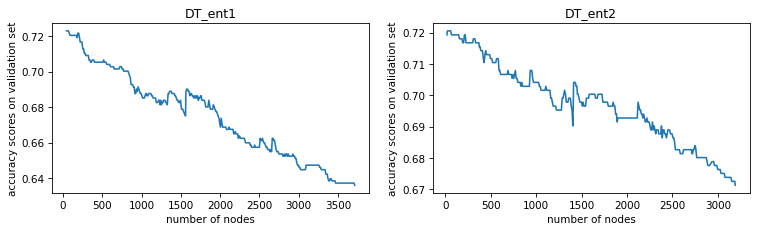

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12, 3), dpi=75)
ax1.plot(numOfNodes_ent1, acc_ent1)
ax1.set_ylabel("accuracy scores on validation set")
ax1.set_xlabel("number of nodes")
ax1.set_title("DT_ent1")
ax2.plot(numOfNodes_ent2, acc_ent2)
ax2.set_ylabel("accuracy scores on validation set")
ax2.set_xlabel("number of nodes")
ax2.set_title("DT_ent2")

# plt.savefig("DT_ent_comparison.png")
# files.download("DT_ent_comparison.png")

In [ ]:
# final test using gini on data set discrete_df2
DT_gini2.fit(x_train2, y_train2)
greedypruning(DT_gini2, DT_gini2.root, best_accuracy, acc_gini2, numOfNodes_gini2, x_validate2, y_validate2)
p_test = DT_gini2.predict(x_test2)
print(p_test)
test_acc = accuracy_score(p_test, y_test2)
print('accuracy: {:.4f}'.format(test_acc))

[0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 